In [ ]:
import os
import numpy as np
import pandas as pd
import re
import time
# import helper
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score

import torch
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from PIL import Image,ImageDraw,ImageFont
from torch.optim import lr_scheduler


In [ ]:
os.chdir('/content/drive/MyDrive')

In [ ]:
data_transforms={"train":transforms.Compose([transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                    ]),
'val':transforms.Compose([transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                    ])}

image_datasets = {x: datasets.ImageFolder(os.path.join('hymenoptera_data', x),data_transforms[x])for x in ['train', 'val']}
dataloader={x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,shuffle=True) for x in ['train', 'val'] }

dataset_size={x :len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


print('class names {}'.format(len(dataloader['train'])))
print('{} batches in training'.format(len(dataloader['train'])))
print('{} batches in validation'.format(len(dataloader['val'])))
print('{} training images'.format(dataset_size['train']))
print('{} validation images'.format(dataset_size['val']))

class names 61
61 batches in training
39 batches in validation
244 training images
153 validation images


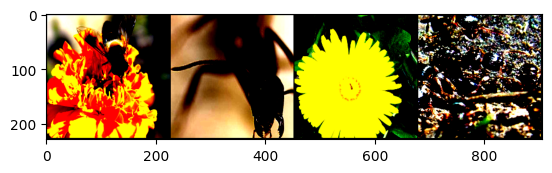

In [ ]:
inputs, classes = next(iter(dataloader['train']))
grid = make_grid(inputs)
plt.imshow(grid.permute(1, 2, 0))

In [ ]:
# model=torchvision.models.resnet18(pretrained=True)
# model1=torchvision.models.efficientnet_v2_l(pretrained=True)
model=torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 141MB/s]


In [ ]:
for param in model.parameters():
  param.requires_grad=True

num_ftrs=model.classifier[6].in_features
model.classifier[6]=nn.Linear(num_ftrs,2)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.008,momentum=0.9)

In [ ]:
checkpoint_file = "model_checkpoint.pth"

if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

Resuming training from epoch 72


In [9]:
epochs=100
train_acc=[]
train_loss=[]

checkpoint_file = "model_checkpoint.pth"

if os.path.exists(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"]
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0

for e in range(start_epoch,epochs):
  correct=0
  for images,labels in dataloader['train']:
    optimizer.zero_grad()

    output=model(images)
    loss=criterion(output,labels)
    loss.backward()
    optimizer.step()
    _,preds=torch.max(output,1)
    correct+=(preds==labels).sum().item()

  print(e)
  train_acc.append(100* correct/dataset_size['train'])
  train_loss.append(loss.item())


  checkpoint = {
    "epoch": e + 1,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}
  torch.save(checkpoint, "model_checkpoint.pth")


print('Loss {}, train Accuracy {}' .format(train_loss[-2:],train_acc[-2:]))
plt.plot(range(1,epochs+1),train_acc)




Resuming training from epoch 72
72
73
74
75
76


KeyboardInterrupt: 

In [11]:
train_loss[-2:],train_acc[-2:]

([nan, nan], [50.40983606557377, 50.40983606557377])

ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

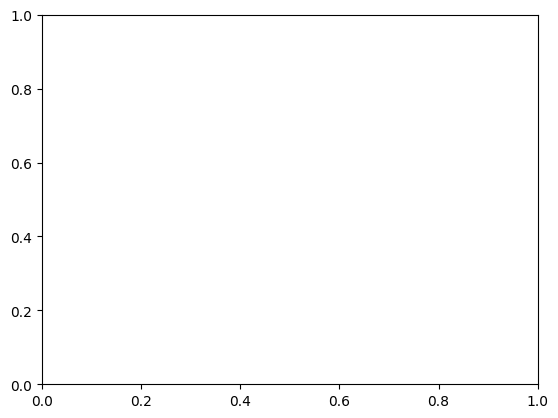

In [10]:
plt.plot(range(1,epochs+1),train_loss)

test Accuracy 45.751633986928105
Validation loss nan
70 153


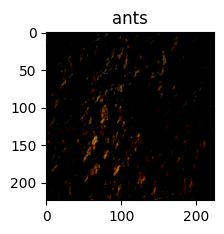

In [12]:
model.eval()
index=0
with torch.no_grad():
  correct=0
  total=0
  total_loss=0
  for images,labels in dataloader['val']:
    output=model(images)
    _,predicted=torch.max(output.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

    loss=criterion(output,labels)
    total_loss+=loss.item()*labels.size(0)
    avg_loss=total_loss/total

  print('test Accuracy {}' .format(100 * correct/ total))
  print('Validation loss {}'.format(avg_loss))
  print(correct,total)

  num_images_in_batch = images.shape[0]

  for i in range(min(5, num_images_in_batch)):
    index+=1
    ax=plt.subplot(2,2,index)
    ax.set_title('{}'.format(class_names[predicted[i]]))
    img=images.cpu().data[i].numpy()
    plt.imshow(img.transpose((1, 2, 0)))

